In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel
import daft

This is based on the [homework of week 3](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week03.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
"The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others."
<br>

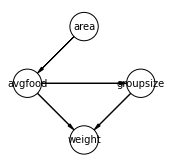

In [2]:
dag_fox = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"], 
    edges=[("area", "avgfood"), 
           ("avgfood", "groupsize"),
           ("avgfood", "weight"),
           ("groupsize", "weight")]
)

pgm = daft.PGM()
coordinates = {"avgfood":(0, 1), "area":(1, 2), "groupsize":(2, 1), "weight":(1, 0)}

for node in dag_fox.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag_fox.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

In [3]:
df = pd.read_csv("../data/foxes.csv", sep=";")
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [4]:
df.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


In [5]:
def standardize(series):
    series_std = (series - series.mean()) / series.std()
    return series_std

In [6]:
df['avgfood_std'] = standardize(df.avgfood)
df['groupsize_std'] = standardize(df.groupsize)
df['area_std'] = standardize(df.area)
df['weight_std'] = standardize(df.weight)
df.head()

,group,avgfood,groupsize,area,weight,avgfood_std,groupsize_std,area_std,weight_std
0,1,0.37,2,1.09,5.02,-1.924829,-1.524089,-2.239596,0.414135
1,1,0.37,2,1.09,2.84,-1.924829,-1.524089,-2.239596,-1.427046
2,2,0.53,2,2.05,5.33,-1.118035,-1.524089,-1.205508,0.675954
3,2,0.53,2,2.05,6.07,-1.118035,-1.524089,-1.205508,1.300942
4,3,0.49,2,2.12,5.85,-1.319734,-1.524089,-1.130106,1.115135


## Infering the total causal influence of territory size on weight. 

In [7]:
x_bar_std = df['area_std'].mean()

with pm.Model() as m_fox:
    a = pm.Normal('a', 2, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA*(df['area_std'] - x_bar_std)
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    trace_fox = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5585.54draws/s]


In [8]:
az.summary(trace_fox, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.07,0.09,-0.10,0.25
bA,0.02,0.09,-0.14,0.20
sigma,1.01,0.07,0.89,1.15


It seems there's no correlation between territory size and weight of the foxes. It can be seen by the coeficient **bA** that is around zero.

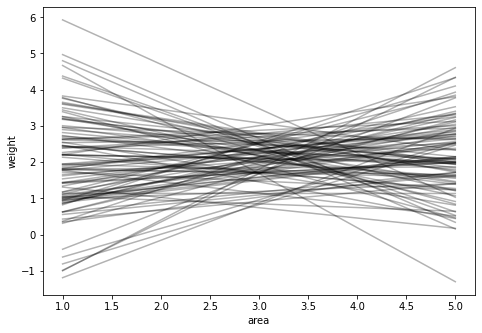

In [9]:
N = 100

x = np.linspace(int(df.area.min()), int(df.area.max()), 100)
x_bar = df.area.mean()

a = stats.norm.rvs(2, 0.5, N)
bA = stats.norm.rvs(0, 0.5, N)
#bA = stats.lognorm.rvs(s=1, loc=0, scale=1, size=N)

fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])

for i in range(N):
    pred = a[i] + bA[i]*(x - x_bar)
    
    a1.plot(x, pred, c='black', alpha=0.3)
    a1.set_xlabel('area')
    a1.set_ylabel('weight')

## Infering the total causal impact of food.
To infer the total causal impact of food on weight cannot 

In [10]:
x_bar_std = df['area_std'].mean()

with pm.Model() as m_fox:
    a = pm.Normal('a', 0, 1)
    #bA = pm.Normal('bA', 0, 1)
    bF = pm.Normal('bF', 0, 1)
    
    sigma = pm.Exponential('sigma', 1)
    #mu = a + bA*df['area_std'] + bF*df['avgfood_std']
    mu = a + bF*df['avgfood_std']
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    trace_fox = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6061.36draws/s]


In [11]:
az.summary(trace_fox, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.00,0.10,-0.19,0.17
bF,-0.02,0.10,-0.20,0.16
sigma,1.01,0.07,0.88,1.13


Adding food doesn't impact the effect of territory size over weight.
This is an expected outcome when analysing the DAG we can see that by conditioning on **avgfood** the path between **area** and **weight** is blocked.
<br><br>
To estimate the total causal influence of food we have to condition on **groupsize** as it's working as a backdoor path. 

## Infering the causal impact of group size.
To infer the total causal impact of **groupsize** on **weight** we need to block the path that passes through **avgfood**.

In [12]:
x_bar_std = df['area_std'].mean()

with pm.Model() as m_fox:
    a = pm.Normal('a', 0, 1)
    bG = pm.Normal('bG', 0, 1)
    bF = pm.Normal('bF', 0, 1)
    
    sigma = pm.Exponential('sigma', 1)
    mu = a + bG*df['groupsize_std'] + bF*df['avgfood_std']
    
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=df['weight_std'])
    
    trace_fox = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, bG, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3168.43draws/s]
The acceptance probability does not match the target. It is 0.8789773287342961, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
az.summary(trace_fox, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.00,0.09,-0.17,0.16
bG,-0.69,0.20,-1.03,-0.29
bF,0.59,0.20,0.21,0.95
sigma,0.96,0.06,0.85,1.08


/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'bG'}>,
       <AxesSubplot:title={'center':'bF'}>], dtype=object)

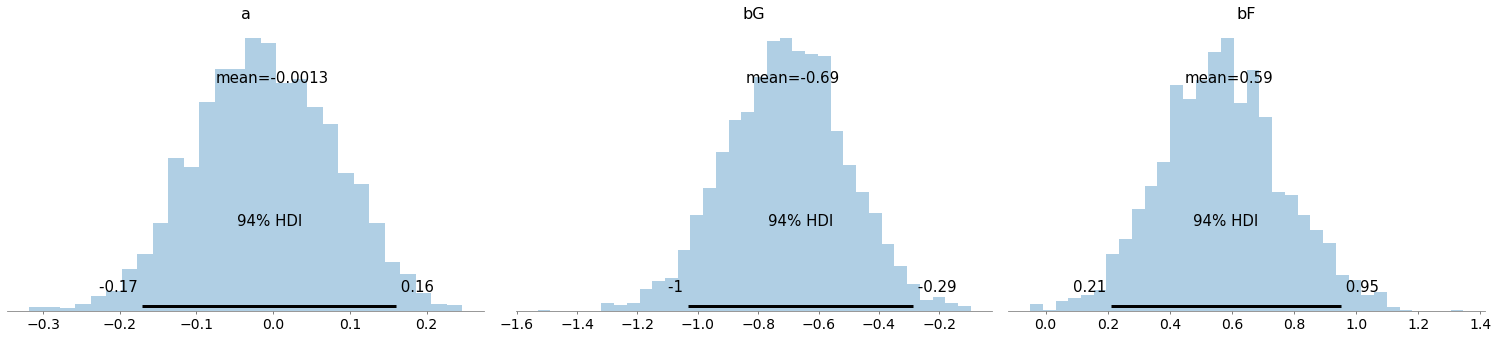

In [14]:
az.plot_posterior(trace_fox, var_names=['a','bG', 'bF'], kind='hist')

According to the posterior distributions, the smaller the **groupsize** and the more **food** available, in the territory, the bigger the **weight**.
<br>
<br>
Besides, based on the previous regressions, given **food** and **groupsize** are correlated to **weight** but the **area** is irrelevant.

---

---

In [15]:
%load_ext watermark
%watermark -iv -v -nuw

numpy   1.19.1
seaborn 0.10.1
pandas  1.1.1
daft    0.1.0
arviz   0.10.0
pymc3   3.8
last updated: Mon Nov 30 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
